In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab Notebooks/craud/project/cv_project/'

Mounted at /content/drive


In [ ]:
%cd $path

/content/drive/My Drive/Colab Notebooks/craud/project/cv_project


In [ ]:
!pip install -q -r requirements.txt

     |████████████████████████████████| 523 kB 5.2 MB/s 
     |████████████████████████████████| 376 kB 55.5 MB/s 
     |████████████████████████████████| 596 kB 90.3 MB/s 
     |████████████████████████████████| 132 kB 75.8 MB/s 
     |████████████████████████████████| 829 kB 72.2 MB/s 
     |████████████████████████████████| 329 kB 62.5 MB/s 
     |████████████████████████████████| 1.1 MB 57.2 MB/s 
     |████████████████████████████████| 631 kB 65.2 MB/s 
     |████████████████████████████████| 192 kB 65.6 MB/s 
     |████████████████████████████████| 160 kB 71.6 MB/s 
     |████████████████████████████████| 271 kB 66.3 MB/s 


In [ ]:
%load_ext autoreload

In [ ]:
import pandas as pd
import numpy as np
import ipyplot
import torch
import pytorch_lightning as pl
from sklearn.metrics import f1_score
%matplotlib inline


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        


In [ ]:
!pip install -U albumentations


     |████████████████████████████████| 102 kB 5.1 MB/s 
     |████████████████████████████████| 47.6 MB 1.2 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import albumentations 
from albumentations.pytorch import ToTensorV2

In [ ]:
from src.model import ImageClassifier
from src.utils import ImagesDataset, evaluate_model
from src.transforms import transform_val, transform_train
from src import params

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1953: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


# Load dataset

In [ ]:
import re

In [ ]:
data_path = path+'dataset_students/classification'
df = pd.read_csv(f'{data_path}/crowd_labelled.csv')
df.head()

,INPUT:image,OUTPUT:result
0,https://toloka.yandex.com/api/proxy/pull-pictu...,1.0
1,https://toloka.yandex.com/api/proxy/pull-pictu...,1.0
2,https://toloka.yandex.com/api/proxy/pull-pictu...,1.0
3,https://toloka.yandex.com/api/proxy/pull-pictu...,1.0
4,https://toloka.yandex.com/api/proxy/pull-pictu...,1.0


In [ ]:
df.rename(columns={'INPUT:image': 'img_path',
                   'OUTPUT:result': 'label'}, inplace=True)

In [ ]:
def mapper(url):
    image_name = re.search(r'\/([0-9].*\.[a-zA-Z].*)', url).group(1)
    return f'{data_path}/train_unlabelled/{image_name}'

df['label'] = df['label'].astype('int')
df['img_path'] = df['img_path'].apply(mapper)

In [ ]:
image_paths = df['img_path'].values
labels = df['label'].values

In [ ]:
len(image_paths)

7497

In [ ]:
df

,img_path,label
0,/content/drive/My Drive/Colab Notebooks/craud/...,1
1,/content/drive/My Drive/Colab Notebooks/craud/...,1
2,/content/drive/My Drive/Colab Notebooks/craud/...,1
3,/content/drive/My Drive/Colab Notebooks/craud/...,1
4,/content/drive/My Drive/Colab Notebooks/craud/...,1
...,...,...
7492,/content/drive/My Drive/Colab Notebooks/craud/...,1
7493,/content/drive/My Drive/Colab Notebooks/craud/...,1
7494,/content/drive/My Drive/Colab Notebooks/craud/...,1
7495,/content/drive/My Drive/Colab Notebooks/craud/...,1


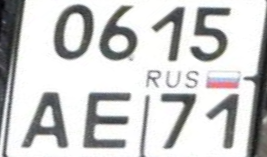

In [ ]:
from IPython.display import Image
Image(filename=df.loc[0]['img_path']) 

In [ ]:
df['label'].value_counts()

0    6829
1     668
Name: label, dtype: int64

In [ ]:
ipyplot.plot_class_tabs(image_paths, labels)

# Train model

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [ ]:
splitter = StratifiedShuffleSplit(n_splits=5, random_state=42)

NUM_WORKERS = 4
for i, (train_index, test_index) in enumerate(splitter.split(image_paths, labels)):
    train_image_paths, train_labels = image_paths[train_index], labels[train_index]
    val_image_paths, val_labels = image_paths[test_index], labels[test_index]

    train_dataset = ImagesDataset(train_image_paths, train_labels,
                                  transform=transform_train)
    val_dataset = ImagesDataset(val_image_paths, val_labels,
                                transform=transform_val)

    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=params.BATCH_SIZE,
                                               num_workers=NUM_WORKERS,
                                               shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_dataset, 
                                             batch_size=params.BATCH_SIZE,
                                             num_workers=NUM_WORKERS,
                                             shuffle=False)
    
    model = ImageClassifier(learning_rate=params.LEARNING_RATE)
    early_stopping = EarlyStopping('val_loss', verbose=True, patience=5)
    trainer = pl.Trainer(
        max_epochs=params.MAX_EPOCHS,
        gpus=-1,
        callbacks=[early_stopping],
    )
    trainer.fit(model, train_loader, val_loader)

    labels_val, predictions = evaluate_model(model, val_dataset)
    score = f1_score(labels_val, predictions, labels=1, average='binary')
    print(f'fold {i} val score = {score}')
    trainer.save_checkpoint(f'model_{i}.ckpt')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 2.2 M 
---------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.906     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.160


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.113


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.090


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.082


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.079


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.067


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.063


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

fold 0 val score = 0.887218045112782


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 2.2 M 
---------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.906     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.205


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 0.137


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.123


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.097


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.086


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.080


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

fold 1 val score = 0.8721804511278195


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 2.2 M 
---------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.906     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_aliv

Training: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.206


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 0.141


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.111


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.103


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.099


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.095


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.087


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

fold 2 val score = 0.8976377952755905


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 2.2 M 
---------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.906     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shut

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.135


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.095


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.078


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.068


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.064


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.064


Validating: 0it [00:00, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

fold 3 val score = 0.931297709923664


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 2.2 M 
---------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.906     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/d

Training: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd7f7d57e60>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.p

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.210


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.146


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.122


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.101


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.094


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.090


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.089


  0%|          | 0/24 [00:00<?, ?it/s]

fold 4 val score = 0.8939393939393939


In [ ]:
n_models = 5
models = []

for i in range(n_models):
    models.append(ImageClassifier.load_from_checkpoint(f'model_{i}.ckpt'))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv2_100_ra-b33bc2c4.pth" to /root/.cache/torch/hub/checkpoints/mobilenetv2_100_ra-b33bc2c4.pth


public sabmission

In [ ]:
import os
data_path = path+'dataset_students/classification/val/'

test_images_paths = [data_path+fname for fname in os.listdir(data_path)]
test_images_dataset = ImagesDataset(test_images_paths, transform=transform_val)

In [ ]:
test_images_paths

['/content/drive/My Drive/Colab Notebooks/craud/project/cv_project/dataset_students/classification/val/1633.png',
 '/content/drive/My Drive/Colab Notebooks/craud/project/cv_project/dataset_students/classification/val/1644.png',
 '/content/drive/My Drive/Colab Notebooks/craud/project/cv_project/dataset_students/classification/val/1635.png',
 '/content/drive/My Drive/Colab Notebooks/craud/project/cv_project/dataset_students/classification/val/1629.png',
 '/content/drive/My Drive/Colab Notebooks/craud/project/cv_project/dataset_students/classification/val/1638.png',
 '/content/drive/My Drive/Colab Notebooks/craud/project/cv_project/dataset_students/classification/val/1636.png',
 '/content/drive/My Drive/Colab Notebooks/craud/project/cv_project/dataset_students/classification/val/1630.png',
 '/content/drive/My Drive/Colab Notebooks/craud/project/cv_project/dataset_students/classification/val/1645.png',
 '/content/drive/My Drive/Colab Notebooks/craud/project/cv_project/dataset_students/clas

In [ ]:
n = len(test_images_paths)

In [ ]:
predictions = np.zeros((n_models, n))

for i, model in enumerate(models):
    _, prediction = evaluate_model(model, test_images_dataset, batch_size=1)
    predictions[i] = np.array(prediction)


  0%|          | 0/2638 [00:00<?, ?it/s]

  0%|          | 0/2638 [00:00<?, ?it/s]

  0%|          | 0/2638 [00:00<?, ?it/s]

  0%|          | 0/2638 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f90c22110e0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f90c22110e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f90c22110e0>
Traceback (most recent call last):
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f90c22110e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/uti

  0%|          | 0/2638 [00:00<?, ?it/s]

    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f90c22110e0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f90c22110e0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError: can only test 

In [ ]:
predictions

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
preds = np.zeros(n)
for i in range(n):
    preds[i] = predictions[0][i]+predictions[1][i]+predictions[2][i]+predictions[3][i]+predictions[4][i]
    if preds[i] >=2.5:
      preds[i] = 1
    else:
      preds[i] = 0

In [ ]:
preds.astype(int)

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
len(preds[preds==1])

211

In [ ]:
img_path = [p.split('/')[-1] for p in test_images_paths]
img_path

['1633.png',
 '1644.png',
 '1635.png',
 '1629.png',
 '1638.png',
 '1636.png',
 '1630.png',
 '1645.png',
 '1661.png',
 '1650.png',
 '1649.png',
 '1655.png',
 '1665.png',
 '1646.png',
 '1657.png',
 '1647.png',
 '1651.png',
 '1663.png',
 '1656.png',
 '1660.png',
 '1652.png',
 '1659.png',
 '1648.png',
 '1658.png',
 '1654.png',
 '1662.png',
 '1653.png',
 '1664.png',
 '1671.png',
 '1668.png',
 '1676.png',
 '1666.png',
 '1672.png',
 '1670.png',
 '1680.png',
 '1682.png',
 '1669.png',
 '1679.png',
 '1677.png',
 '1673.png',
 '1678.png',
 '1683.png',
 '1674.png',
 '1675.png',
 '1667.png',
 '1681.png',
 '1684.png',
 '1690.png',
 '1702.png',
 '1692.png',
 '1699.png',
 '1688.png',
 '1696.png',
 '1703.png',
 '1701.png',
 '1687.png',
 '1685.png',
 '1697.png',
 '1695.png',
 '1689.png',
 '1694.png',
 '1691.png',
 '1698.png',
 '1700.png',
 '1693.png',
 '1686.png',
 '1708.png',
 '1709.png',
 '1716.png',
 '1719.png',
 '1705.png',
 '1718.png',
 '1717.png',
 '1707.png',
 '1704.png',
 '1710.png',
 '1711.png',

In [ ]:
a = {}
for i in range(len(preds)):
  a[img_path[i]] = preds.astype(int)[i]
a

{'1633.png': 1,
 '1644.png': 0,
 '1635.png': 0,
 '1629.png': 0,
 '1638.png': 0,
 '1636.png': 0,
 '1630.png': 0,
 '1645.png': 0,
 '1661.png': 0,
 '1650.png': 0,
 '1649.png': 0,
 '1655.png': 0,
 '1665.png': 0,
 '1646.png': 0,
 '1657.png': 0,
 '1647.png': 0,
 '1651.png': 0,
 '1663.png': 1,
 '1656.png': 1,
 '1660.png': 0,
 '1652.png': 0,
 '1659.png': 0,
 '1648.png': 0,
 '1658.png': 0,
 '1654.png': 0,
 '1662.png': 0,
 '1653.png': 0,
 '1664.png': 0,
 '1671.png': 1,
 '1668.png': 0,
 '1676.png': 0,
 '1666.png': 0,
 '1672.png': 0,
 '1670.png': 0,
 '1680.png': 0,
 '1682.png': 0,
 '1669.png': 1,
 '1679.png': 0,
 '1677.png': 0,
 '1673.png': 0,
 '1678.png': 0,
 '1683.png': 1,
 '1674.png': 1,
 '1675.png': 0,
 '1667.png': 0,
 '1681.png': 0,
 '1684.png': 0,
 '1690.png': 0,
 '1702.png': 0,
 '1692.png': 0,
 '1699.png': 0,
 '1688.png': 0,
 '1696.png': 0,
 '1703.png': 0,
 '1701.png': 0,
 '1687.png': 0,
 '1685.png': 0,
 '1697.png': 0,
 '1695.png': 0,
 '1689.png': 0,
 '1694.png': 0,
 '1691.png': 0,
 '1698.p

In [ ]:
res_img = []
res_pred = []
for i in range(len(preds)):
  img = f'{i}.png'
  res_img.append(img)
  res_pred.append(a[img])


In [ ]:
# Only the image name will be used when evaluating, the rest of the path does not matter
submission_df = pd.DataFrame({'img_path': res_img, 'label': res_pred})
submission_df.to_csv(path +'submission_public.csv', index=False)

Private submission

In [ ]:
import os
data_path = path+'dataset_students/classification/test/'

test_images_paths = [data_path+fname for fname in os.listdir(data_path)]

In [ ]:
test_images_dataset = ImagesDataset(test_images_paths, transform=transform_val)

In [ ]:
n = len(test_images_paths)
n

5925

In [ ]:
predictions = np.zeros((n_models, n))

for i, model in enumerate(models):
    _, prediction = evaluate_model(model, test_images_dataset, batch_size=1)
    predictions[i] = np.array(prediction)

  0%|          | 0/5925 [00:00<?, ?it/s]

  0%|          | 0/5925 [00:00<?, ?it/s]

  0%|          | 0/5925 [00:00<?, ?it/s]

  0%|          | 0/5925 [00:00<?, ?it/s]

  0%|          | 0/5925 [00:00<?, ?it/s]

In [ ]:
preds = np.zeros(n)
for i in range(n):
    preds[i] = predictions[0][i]+predictions[1][i]+predictions[2][i]+predictions[3][i]+predictions[4][i]
    if preds[i] >=2.5:
      preds[i] = 1
    else:
      preds[i] = 0

In [ ]:
preds = preds.astype(int)

In [ ]:
preds

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
img_path = [p.split('/')[-1] for p in test_images_paths]
img_path[0]

'2302.png'

In [ ]:
a = {}
for i in range(len(preds)):
  a[img_path[i]] = preds[i]
a

{'2302.png': 0,
 '4773.png': 0,
 '3008.png': 0,
 '4767.png': 0,
 '2316.png': 0,
 '5479.png': 0,
 '2470.png': 0,
 '4001.png': 0,
 '1179.png': 0,
 '1192.png': 0,
 '4798.png': 1,
 '360.png': 0,
 '4954.png': 1,
 '406.png': 0,
 '5492.png': 0,
 '3785.png': 0,
 '1838.png': 0,
 '374.png': 0,
 '5486.png': 0,
 '4940.png': 0,
 '412.png': 0,
 '3791.png': 1,
 '3949.png': 0,
 '1186.png': 0,
 '3961.png': 0,
 '1810.png': 0,
 '4968.png': 0,
 '1804.png': 0,
 '348.png': 0,
 '3975.png': 0,
 '2841.png': 0,
 '88.png': 0,
 '610.png': 0,
 '1390.png': 1,
 '1384.png': 0,
 '604.png': 0,
 '3593.png': 0,
 '2855.png': 0,
 '5684.png': 0,
 '176.png': 0,
 '638.png': 0,
 '5860.png': 0,
 '2869.png': 0,
 '3746.png': 0,
 '1151.png': 0,
 '1637.png': 0,
 '2458.png': 0,
 '4029.png': 0,
 '3020.png': 0,
 '5337.png': 0,
 '5451.png': 0,
 '1145.png': 0,
 '1623.png': 0,
 '4997.png': 0,
 '3034.png': 0,
 '3752.png': 0,
 '2464.png': 0,
 '5323.png': 0,
 '4015.png': 0,
 '5445.png': 0,
 '4983.png': 0,
 '1435.png': 0,
 '3222.png': 0,
 '3

In [ ]:
len(preds[preds==1])

478

In [ ]:
res_img = []
res_pred = []
i = 0
while i < 5874:
  img = f'{i}.png'
  res_img.append(img)
  res_pred.append(a[img])
  i += 1

In [ ]:
# Only the image name will be used when evaluating, the rest of the path does not matter
submission_df = pd.DataFrame({'img_path': res_img, 'label': res_pred})
submission_df.to_csv('submission.csv', index=False)